已经了解了如何定义神经网络，计算损失值和网络里权重的更新。
# 如何处理数据
通常来说，当你处理图像，文本，语音或者视频数据时，可以使用标准python包将数据加载成numpy数组格式，然后将这个数组转换成torch.*Tensor
* 对于图像，可以用Pillow，OpenCV
* 对于语音，可以用scipy，Librosa
* 对于文本，可以直接使用python或Cpython基础数据加载模块，或者用NLTK和SpaCy

特别是对于视觉，torch已经创建了一个叫做torchvision的包，该包含有支持加载类似Imagenet、CIFAR10、MNIST等公共数据集的数据加载模块torchvision.datasets和支持加载图像数据的数据转换模块torch.utils.data.DataLoader。这提供了极大的便利，并且避免了编写“样板代码”。

在本教程中，我们将使用CIFAR10数据集。它具有一下类别：飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船、卡车。CIFAR-10数据集中的图片尺寸为3x32x32，即尺寸为32x32像素的3通道彩色图像。

# 训练图像分类器
我们将按顺序执行以下步骤：
1. 使用torchvision加载和归一化CIFAR-10训练和测试数据集
2. 定义一个卷积神经网络
3. 定义一个损失函数
4. 在训练样本数据上训练网络
5. 在测试样本数据上测试网络

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# torchvision数据集的输出是范围在[0,1]之间的PILImage，我们将它们转换成归一化范围为[-1,1]之间的张量Tensors。
transform = transforms.Compose(
    [
        transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


0it [00:00, ?it/s]

170500096it [3:06:39, 104418.89it/s]                                

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


170500096it [3:06:57, 104418.89it/s]

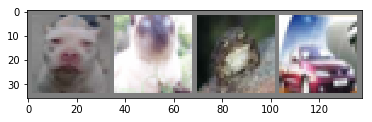

  dog   cat  frog   car


In [8]:
# 展示一些训练图片
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some dandom training images    
dataiter = iter(trainloader)
images, labels = dataiter.next()
# print(images)

# show images
imshow(torchvision.utils.make_grid(images))
# print lables
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
net = Net()

In [14]:
# 定义一个损失函数和优化器，让我们使用分类交叉熵Cross-Entropy作为损失函数，动量SGD做优化器
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [15]:
# 开始训练网络，我们只需要在数据迭代器上循环传给网络和优化器输入就可以了
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%5d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
            
print('Finished Training')
            

[    1,  2000] loss: 2.303
[    1,  4000] loss: 2.299
[    1,  6000] loss: 2.291
[    1,  8000] loss: 2.273
[    1, 10000] loss: 2.221
[    1, 12000] loss: 2.144
[    2,  2000] loss: 2.047
[    2,  4000] loss: 1.977
[    2,  6000] loss: 1.943
[    2,  8000] loss: 1.888
[    2, 10000] loss: 1.852
[    2, 12000] loss: 1.788
Finished Training


In [16]:
# 保存训练的模型
PATH = './cifar_net.pth'
torch.save(net.state_dict, PATH)

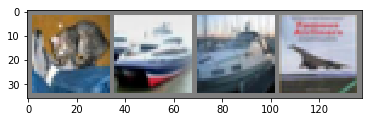

GroundTruth:   cat  ship  ship plane


In [18]:
# 在测试集上测试网络
'''
我们已经对网络进行了两次训练，但是我们还需要检查网络学到了什么
我们将铜鼓预测神经网络输出的类别标签并根据实际情况进行检查。如果预测正确，则将样本添加到正确预测列表。
'''
# 第一步，显示一张图片
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [20]:
# 这里是加载已经训练好的网络模型，但是我们现在并不需要这么做

'''
net = Net()
net.load_state_dict(torch.load(PATH))
'''

# 现在看一下网络的预测是什么
outputs = net(images)
print(outputs)

tensor([[-1.8899e+00,  3.4770e-04,  2.2519e-02,  1.6725e+00,  5.4346e-02,
          1.2193e+00,  1.4275e+00, -3.8161e-01, -1.0173e+00, -6.2225e-01],
        [ 2.4601e+00,  3.0866e+00, -1.8832e+00, -1.3338e+00, -2.5772e+00,
         -1.9507e+00, -2.8243e+00, -1.8077e+00,  4.6918e+00,  2.5559e+00],
        [ 1.1058e+00,  2.1344e+00, -1.3945e+00, -1.8952e-01, -2.0894e+00,
         -5.2777e-01, -1.6618e+00, -1.0187e+00,  2.6211e+00,  1.7037e+00],
        [ 2.6989e+00,  2.0415e+00, -1.0849e+00, -1.3638e+00, -1.6917e+00,
         -1.7001e+00, -2.6660e+00, -1.0740e+00,  3.6161e+00,  1.5312e+00]],
       grad_fn=<AddmmBackward>)


In [22]:
# 输出是预测与10个类的近似程度，与某个类的近似程度越高，网络就越认为图像是属于这一类别的，所以，让我们打印其中最相思类别标签：
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ''.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat ship ship ship


In [23]:
#结果还好，我们看一下在整个测试集上的表现
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct/total))

Accuracy of the network on the 10000 test images: 35 %


In [25]:
# 看一下各类的表现：
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100*class_correct[i]/class_total[i]))

Accuracy of plane : 40 %
Accuracy of   car : 40 %
Accuracy of  bird :  3 %
Accuracy of   cat : 35 %
Accuracy of  deer : 13 %
Accuracy of   dog :  4 %
Accuracy of  frog : 69 %
Accuracy of horse : 49 %
Accuracy of  ship : 56 %
Accuracy of truck : 42 %


In [26]:
# 如何在GPU上训练，如果我们有可用的CUDA，首先让我们将设备定义为第一个可见的cuda设备
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


In [ ]:
net.to(device) # 将递归遍历所有模块，并将其参数和缓冲区转换为CUDA张量

#每一步的输入和目标也发送到GPU
inputs, labels = data[0].to(device), data[1].to(device)